In [1]:
# Make some data
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


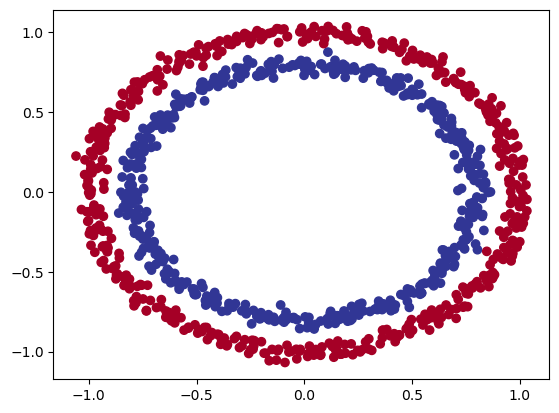

In [6]:
# Visualise graphically
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [7]:
# Input and Output Shapes
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# First example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for 1 sample of x: {X_sample} and for y: {y_sample}")
print(f"Shapes for 1 sample of x: {X_sample.shape} and for y: {y_sample.shape}")

Values for 1 sample of x: [0.75424625 0.23148074] and for y: 1
Shapes for 1 sample of x: (2,) and for y: ()


In [9]:
# Turn data into Tensors and create train / test splits
import torch
print(f"Torch version {torch.__version__}")


Torch version 2.1.2


In [10]:
# Turn into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.type(), X.dtype, y.dtype

('torch.FloatTensor', torch.float32, torch.float32)

In [11]:
# split into training and test set
# Random Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [12]:
X_test.shape

torch.Size([200, 2])

In [13]:
# Build blue and red dot classifier model
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2 nn.Linear layers capable of handling the shapes of the data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # 2 -> 5
        # hidden layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # 5 -> 1  output layer

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> l1 -> l2 -> output


# Instance of Model class and send to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cpu')

In [16]:
# Same as above model using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=32), # 2 -> 5
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1) # 5 -> 1  output layer
).to(device)

In [17]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
    print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
    print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3017],
        [-0.0852],
        [-0.2721],
        [-0.0150],
        [-0.2853],
        [ 0.1463],
        [-0.2891],
        [-0.1229],
        [ 0.1432],
        [-0.2912]])

First 10 test labels:
tensor([0., 1., 0., 0., 1., 0., 1., 0., 1., 1.])


In [18]:
# Loss function and Opitimiser for Classification

# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [19]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [20]:
# view first 5 outputs of the forward pass of the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3017],
        [-0.0852],
        [-0.2721],
        [-0.0150],
        [-0.2853]], grad_fn=<SliceBackward0>)

In [21]:
# Use the sigmoid activation function on our logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4252],
        [0.4787],
        [0.4324],
        [0.4963],
        [0.4291]], grad_fn=<SigmoidBackward0>)

In [22]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
# logits -> pred_probs -> pred_labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [23]:
y_test[:5]

tensor([0., 1., 0., 0., 1.])

In [24]:
# Training Loop
# reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# move data onto target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [25]:
# Training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    # logits -> pred_probs -> pred_labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss / accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimiser zero grad
    optimizer.zero_grad()

    # Loss backward (back propogation) calculate the gradients
    loss.backward()

    # Optimiser step
    optimizer.step()


    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss / accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69959, Acc: 49.50% | Test Loss: 0.69406, Test Acc: 49.00%
Epoch: 100 | Loss: 0.68033, Acc: 72.50% | Test Loss: 0.68097, Test Acc: 73.00%
Epoch: 200 | Loss: 0.66654, Acc: 76.38% | Test Loss: 0.66815, Test Acc: 73.00%
Epoch: 300 | Loss: 0.65098, Acc: 85.88% | Test Loss: 0.65326, Test Acc: 80.50%
Epoch: 400 | Loss: 0.63217, Acc: 93.75% | Test Loss: 0.63546, Test Acc: 95.50%
Epoch: 500 | Loss: 0.60975, Acc: 98.00% | Test Loss: 0.61465, Test Acc: 97.50%
Epoch: 600 | Loss: 0.58335, Acc: 98.88% | Test Loss: 0.59051, Test Acc: 98.50%
Epoch: 700 | Loss: 0.55342, Acc: 99.12% | Test Loss: 0.56346, Test Acc: 98.50%
Epoch: 800 | Loss: 0.52004, Acc: 99.12% | Test Loss: 0.53246, Test Acc: 99.50%
Epoch: 900 | Loss: 0.48478, Acc: 99.12% | Test Loss: 0.49865, Test Acc: 100.00%


In [26]:
# Import Helper Functions from github repo
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [27]:
from helper_functions import plot_predictions, plot_decision_boundary

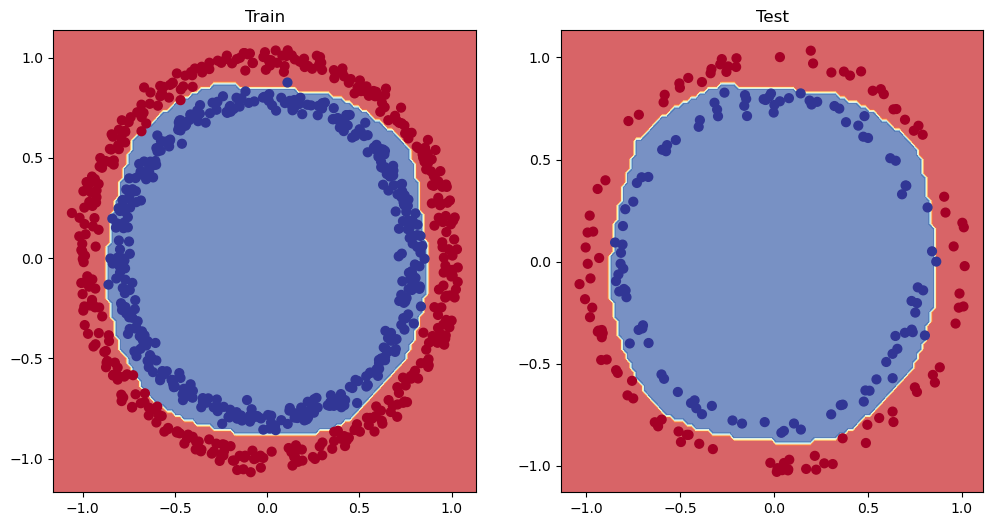

In [28]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [29]:
# Improving a model from model perspective
# more layers
# more hidden units
# Fit for longer
# changing activation fuctions
# learning rate
# change loss function